### Instal exact TF version

Note that this action requires to restart the notebook afterwards

In [0]:
!pip install tensorflow==1.15.0
import tensorflow as tf
print(tf.__version__)

1.15.0


### Clone necessary repositories

In [0]:
from pathlib import Path
import sys

repo_dir = "/content/repo"
!git clone https://github.com/Spidy20/face_mask_detection "$repo_dir"
sys.path.append(repo_dir)

object_detection_dir = Path("/content/object_detection")
!git clone https://github.com/tensorflow/models "$object_detection_dir"
sys.path.append(str(object_detection_dir / "research"))

!sudo apt-get install protobuf-compiler python-pil python-lxml python-tk
%cd {object_detection_dir / "research"}
!protoc object_detection/protos/*.proto --python_out=.

%cd {repo_dir}

fatal: destination path '/content/repo' already exists and is not an empty directory.
fatal: destination path '/content/object_detection' already exists and is not an empty directory.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
python-lxml is already the newest version (4.2.1-1ubuntu0.1).
python-pil is already the newest version (5.1.0-1ubuntu0.2).
python-tk is already the newest version (2.7.17-1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
/content/object_detection/research
/content/repo


### Download training.rar and unpack it

Since there is no official Google Drive API, we need to install `gdown` module to download from GDrive link.

In [0]:
!pip install gdown
file_id = '1CJlYHoyAr18jjimE0x4H-1WjpE5VJZOO'
!gdown https://drive.google.com/uc?id=$file_id

!unrar x training.rar

In [0]:
# !wget "https://www.chinadailyhk.com/attachments/image/23/46/60/521600_218278/521600_218278_800_auto_jpg.jpg" -O mask_image.jpg
!wget "https://img.etimg.com/thumb/msid-74959025,width-643,imgsize-622136,resizemode-4/mask_istock.jpg" -O mask_image.jpg


--2020-05-03 21:12:10--  https://img.etimg.com/thumb/msid-74959025,width-643,imgsize-622136,resizemode-4/mask_istock.jpg
Resolving img.etimg.com (img.etimg.com)... 178.79.208.44, 87.248.202.99
Connecting to img.etimg.com (img.etimg.com)|178.79.208.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33864 (33K) [image/jpeg]
Saving to: ‘mask_image.jpg’

mask_image.jpg      100%[===================>]  33.07K  --.-KB/s    in 0.004s  

2020-05-03 21:12:10 (7.97 MB/s) - ‘mask_image.jpg’ saved [33864/33864]

--2020-05-03 21:12:11--  https://previews.123rf.com/images/joseh51/joseh511906/joseh51190605313/124776046-tel-aviv-israel-june-10-2019-view-of-unknown-israel-people-walking-in-the-streets-of-tel-aviv-in-the.jpg
Resolving previews.123rf.com (previews.123rf.com)... 23.210.118.152
Connecting to previews.123rf.com (previews.123rf.com)|23.210.118.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177399 (173K) [image/jpeg]
Saving to: ‘non_mas

In [0]:
import os
import cv2
import numpy as np
import tensorflow as tf
import sys

from google.colab.patches import cv2_imshow

# Import utilites
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# Name of the directory containing the object detection module we're using
MODEL_NAME = 'inference_graph'
IMAGE_NAME = 'non_mask_img.jpg'

# Grab path to current working directory
CWD_PATH = os.getcwd()

# for object detection.
PATH_TO_CKPT = os.path.join(CWD_PATH, MODEL_NAME, 'frozen_inference_graph.pb')

# Path to label map file
PATH_TO_LABELS = os.path.join(CWD_PATH, 'training', 'labelmap.pbtxt')

# Path to image
PATH_TO_IMAGE = os.path.join(CWD_PATH,IMAGE_NAME)

# Number of classes the object detector can identify
NUM_CLASSES = 6

# Load the label map.
# Label maps map indices to category names, so that when our convolution
# network predicts `5`, we know that this corresponds to `king`.
# Here we use internal utility functions, but anything that returns a
# dictionary mapping integers to appropriate string labels would be fine
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Load the Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    sess = tf.Session(graph=detection_graph)

# Define input and output tensors (i.e. data) for the object detection classifier

# Input tensor is the image
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Output tensors are the detection boxes, scores, and classes
# Each box represents a part of the image where a particular object was detected
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represents level of confidence for each of the objects.
# The score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

# Number of objects detected
num_detections = detection_graph.get_tensor_by_name('num_detections:0')

In [0]:
def image_inference(image_path):

    # Load image using OpenCV and
    # expand image dimensions to have shape: [1, None, None, 3]
    # i.e. a single-column array, where each item in the column has the pixel RGB value
    image = cv2.imread(image_path)
    image_expanded = np.expand_dims(image, axis=0)

    # Perform the actual detection by running the model with the image as input
    (boxes, scores, classes, num) = sess.run(
        [detection_boxes, detection_scores, detection_classes, num_detections],
        feed_dict={image_tensor: image_expanded})

    # Draw the results of the detection (aka 'visulaize the results')

    vis_util.visualize_boxes_and_labels_on_image_array(
        image,
        np.squeeze(boxes),
        np.squeeze(classes).astype(np.int32),
        np.squeeze(scores),
        category_index,
        use_normalized_coordinates=True,
        line_thickness=8,
        min_score_thresh=0.60)

    # All the results have been drawn on image. Now display the image.
    cv2_imshow(image)

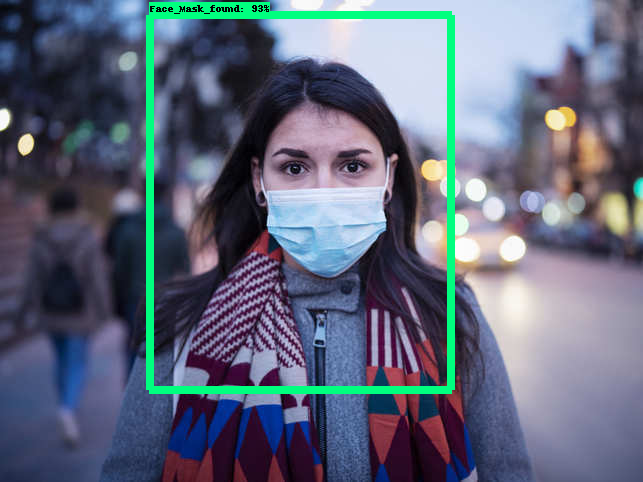

In [0]:
!wget -q "https://img.etimg.com/thumb/msid-74959025,width-643,imgsize-622136,resizemode-4/mask_istock.jpg" -O test_image.jpg
image_inference('test_image.jpg')

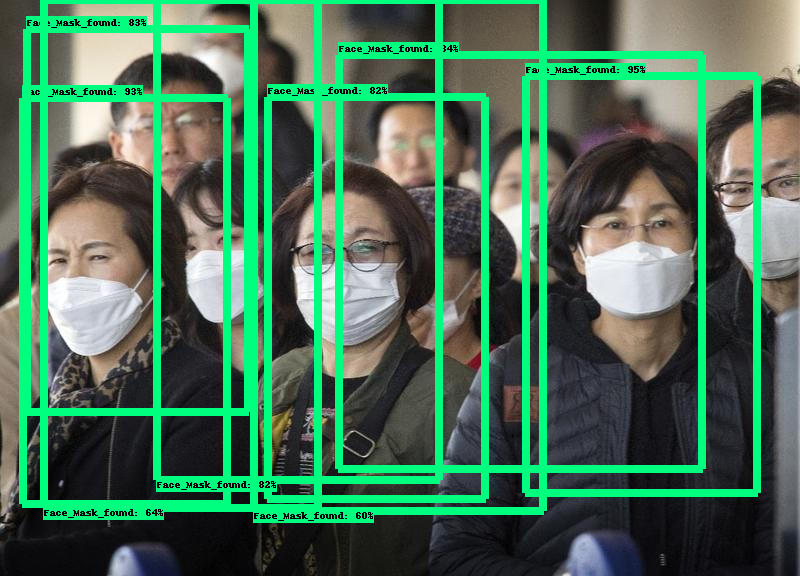

In [0]:
!wget -q "https://www.chinadailyhk.com/attachments/image/23/46/60/521600_218278/521600_218278_800_auto_jpg.jpg" -O test_image.jpg
image_inference('test_image.jpg')

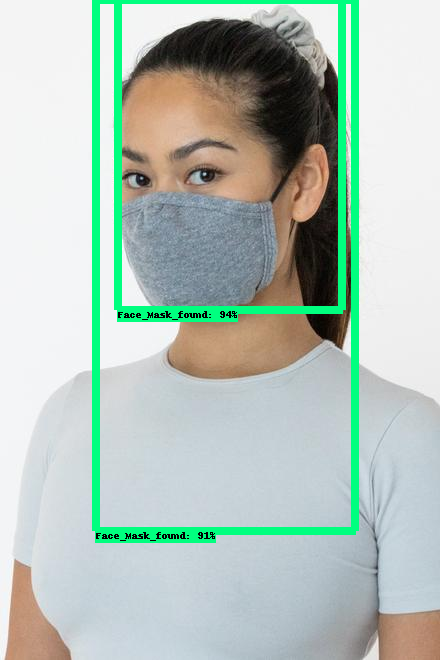

In [0]:
!wget -q "https://cdn.shopify.com/s/files/1/2152/0639/products/heather2_440x.jpg?v=1588298347" -O test_image.jpg
image_inference('test_image.jpg')

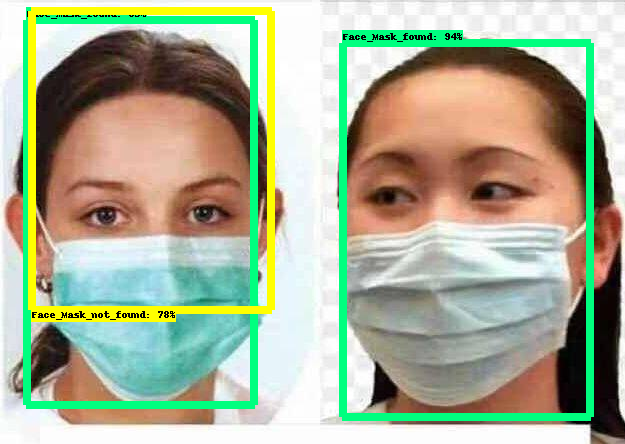

In [0]:
!wget -q "https://apicms.thestar.com.my/uploads/images/2020/01/28/529629.jpg" -O test_image.jpg
image_inference('test_image.jpg')

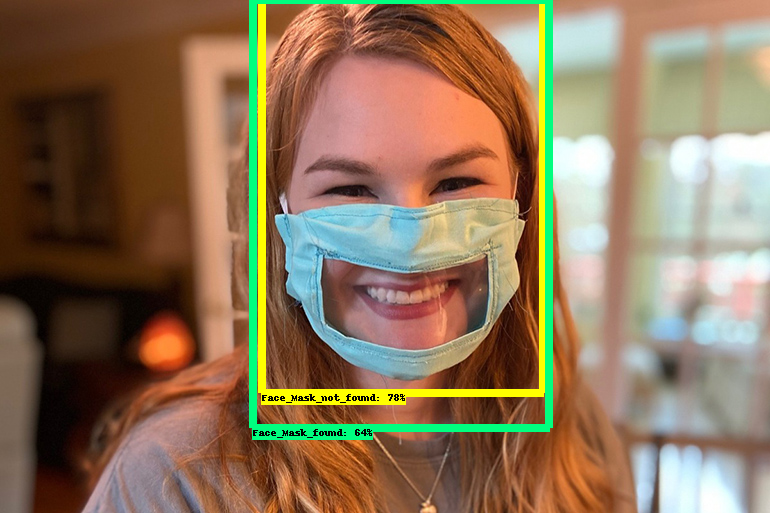

In [0]:
!wget -q "https://www.medgadget.com/wp-content/uploads/2020/04/transparent-face-mask.jpg" -O test_image.jpg
image_inference('test_image.jpg')

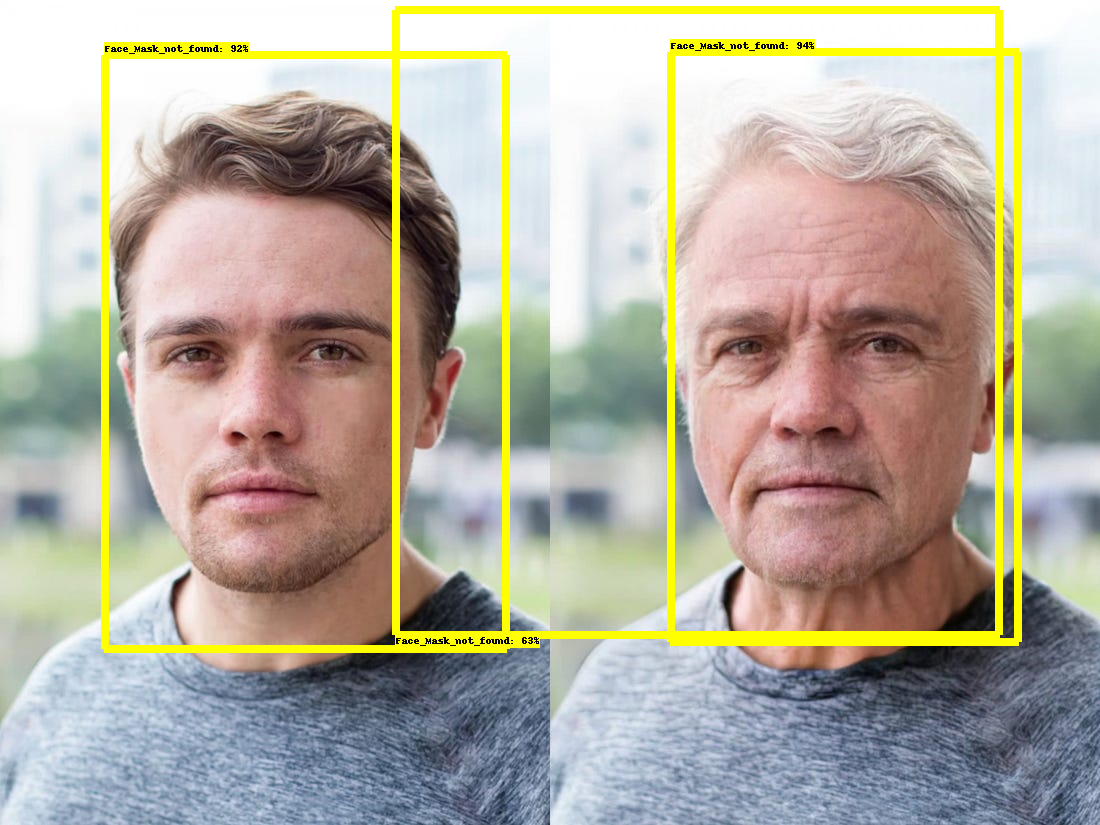

In [0]:
!wget -q "https://i.insider.com/5d37dc5936e03c097f1b4aa3?width=1100&format=jpeg&auto=webp" -O test_image.jpg
image_inference('test_image.jpg')

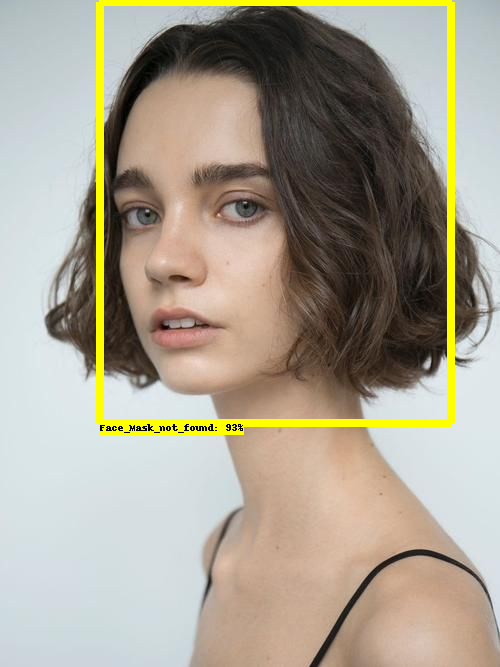

In [0]:
!wget -q "https://i.pinimg.com/564x/b0/e5/28/b0e528e25de26a1f24b7e329f596fb14.jpg" -O test_image.jpg
image_inference('test_image.jpg')

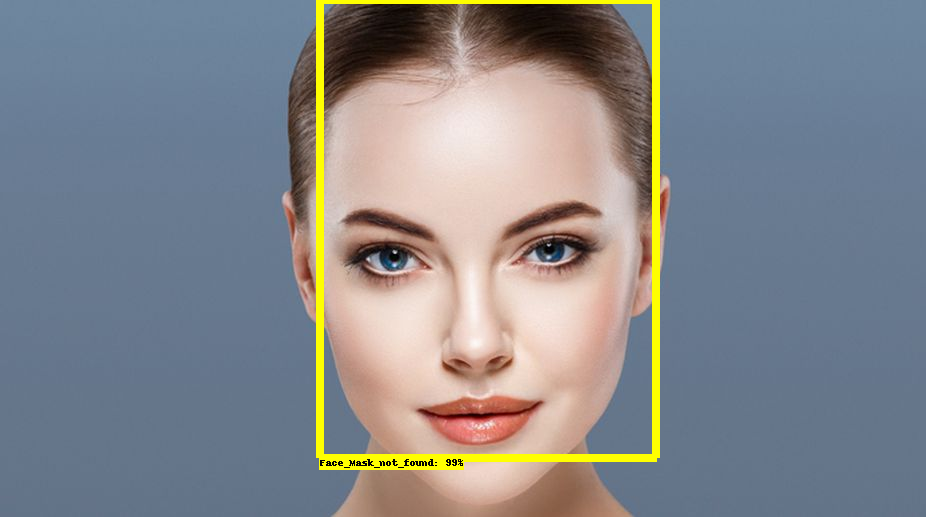

In [0]:
!wget -q "https://www.thestatesman.com/wp-content/uploads/2017/08/1493458748-beauty-face-517.jpg" -O test_image.jpg
image_inference('test_image.jpg')

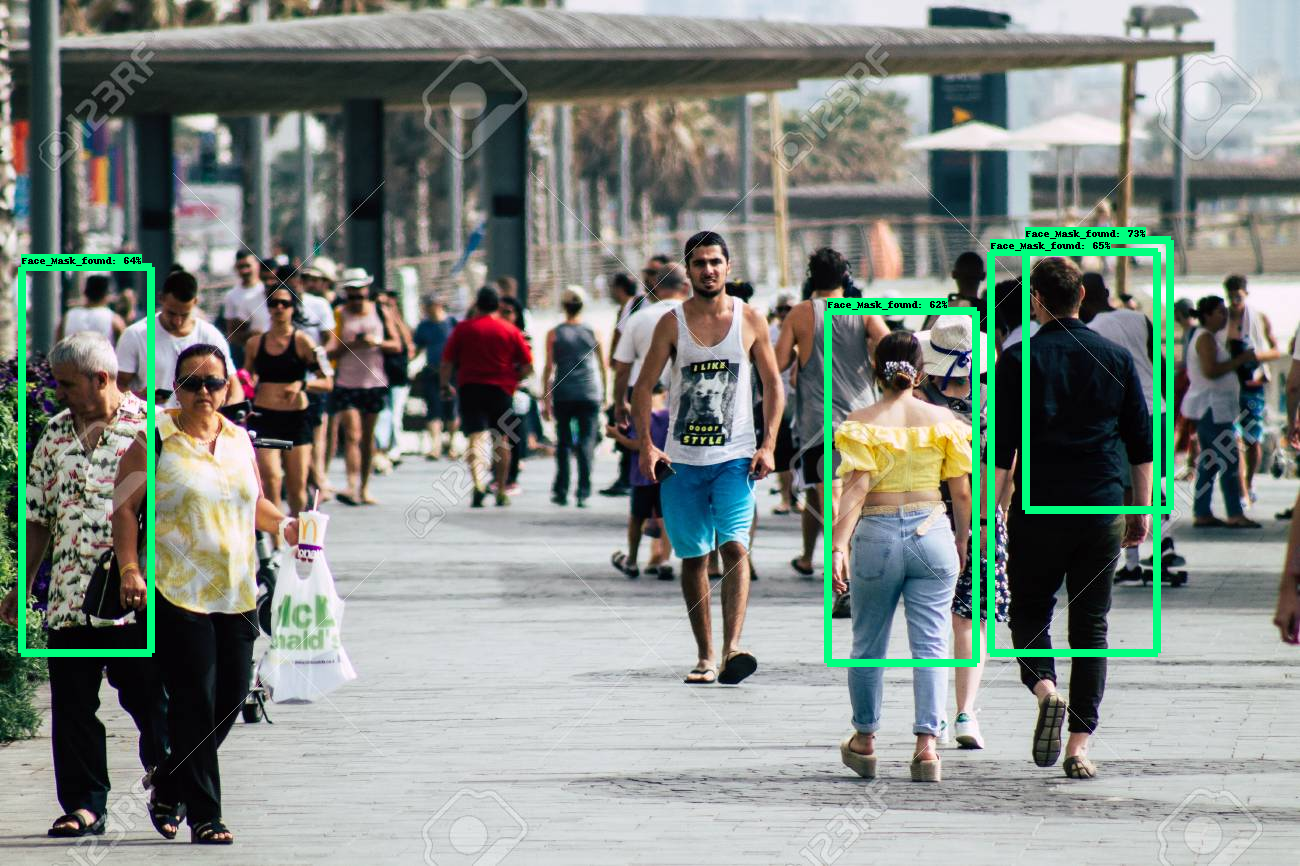

In [0]:
!wget -q "https://previews.123rf.com/images/joseh51/joseh511906/joseh51190605313/124776046-tel-aviv-israel-june-10-2019-view-of-unknown-israel-people-walking-in-the-streets-of-tel-aviv-in-the.jpg" -O test_image.jpg
image_inference('test_image.jpg')